# TQIP Model Inference

This notebook illustrates how the TQIP AI models can be used for inference. 
Models are from the paper "Assesing the Utility of Deep Neural Networks in Dynamic Risk Prediction After Trauma"

Notebooks illustrating data preprocessing as well as model training, validation and testing can be found [here](https://github.com/alexbonde/TQIP).


## Notebook set-up

Import pre-installed packages:

In [1]:
from fastai.tabular.all import *
import matplotlib.pyplot as pl
import joblib
import shap

Set seed for reproducable results:

In [2]:
seed = 42

# python RNG
random.seed(seed)

# pytorch RNGs
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
np.random.seed(seed)

## Define functions for inference: 
* *Published by Zachary Mueller, (https://github.com/muellerzr)*

In [3]:
def _predict(learn:TabularLearner, data:np.array):
    "Predict function for some data on a fastai model"
    device = 'cpu'
    model = learn.model.to(device)
    dl = learn.dls[0]
    nb_cat_cols = len(dl.dataset.cat_names)
    nb_cont_cols = len(dl.dataset.cont_names)
    x_cat = torch.from_numpy(data[:, :nb_cat_cols]).to(device, torch.int64)
    x_cont = torch.from_numpy(data[:, -nb_cont_cols:]).to(device, torch.float32)
    with torch.no_grad():
        pred_probs = learn.model(x_cat, x_cont).cpu().numpy()
    return pred_probs

def _prepare_data(learn:Learner, test_data=None, n_samples:int=128):
    "Prepares train and test data for `SHAP`, pass in a learner with optional data"
    if isinstance(test_data, pd.DataFrame):
        dl = learn.dls.test_dl(test_data)
    else:
        raise ValueError('Input is not supported. Please use a `DataFrame`')
    test_data = pd.merge(dl.cats, dl.conts, left_index=True, right_index=True)
    return test_data

## Load data

Load toy data: 

In [4]:
df = pd.read_csv('toy_data/toy_data.csv') 

## Prehospital Predictions: 

Load the Pre-Hospital Model:

In [27]:
Pre_Hospital_Model = load_learner('models/TQIP_Pre-Hospital_Model.pkl')

Remove the ROC AUC metrics

In [28]:
Pre_Hospital_Model.metrics = None

Create a dataloader:

In [29]:
dl_prehosp = Pre_Hospital_Model.dls.test_dl(df)

Get predictions for the patient:

In [30]:
preds_tens, ys = Pre_Hospital_Model.get_preds(dl=dl_prehosp, n_workers=0)

In [31]:
print('The Prehospital Risk of:')
for i in range(len(Pre_Hospital_Model.dls.y_names)):
    print('\t' + Pre_Hospital_Model.dls.y_names[i], '=', "{:.2%}".format(preds_tens.tolist()[0][i]))

The Prehospital Risk of:
	Central Line-Associated Bloodstream Infection = 0.15%
	Catheter-Associated Urinary Tract Infection = 0.36%
	Superficial Incisional Surgical Site Infection = 0.23%
	Deep Surgical Site Infection = 0.28%
	Organspace Surgical Site Infection = 0.13%
	Ventilator-Associated Pneumonia = 0.78%
	Severe Sepsis = 0.99%
	Deep Vein Thrombosis = 2.21%
	Pulmonary Embolism = 0.83%
	Extremity Compartment Syndrome = 0.17%
	Pressure Ulcer = 0.69%
	Acute Kidney Injury = 2.28%
	Myocardial Infarction = 0.32%
	Cardiac Arrest = 1.70%
	Stroke = 0.54%
	Unplanned Intubation = 2.60%
	Acute Respiratory Distress Syndrome = 1.24%
	Early Mortality = 0.18%
	Late Mortality = 2.50%


### Explain predictions using SHAP:

Load the prehospital explainer:

In [32]:
prehosp_explainer = joblib.load(filename='explainers/prehosp_explainer.bz2')

Prepare the data for prehospital explanations:  

In [33]:
df_inf_prehosp = _prepare_data(Pre_Hospital_Model, df) 

Calculate shap values: 

In [34]:
prehosp_shap_vals = prehosp_explainer.shap_values(df_inf_prehosp)

Waterfall Plot for Central Line-Associated Bloodstream Infection


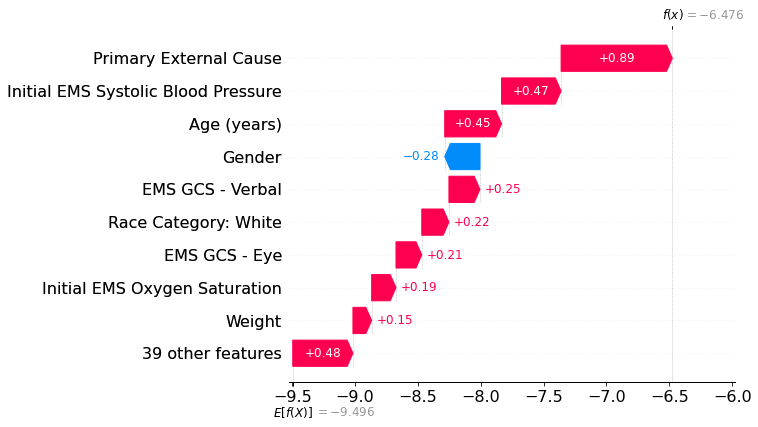

Waterfall Plot for Catheter-Associated Urinary Tract Infection


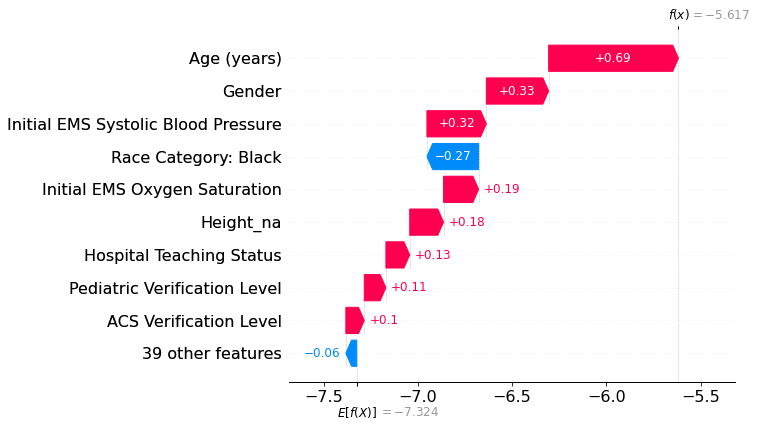

Waterfall Plot for Superficial Incisional Surgical Site Infection


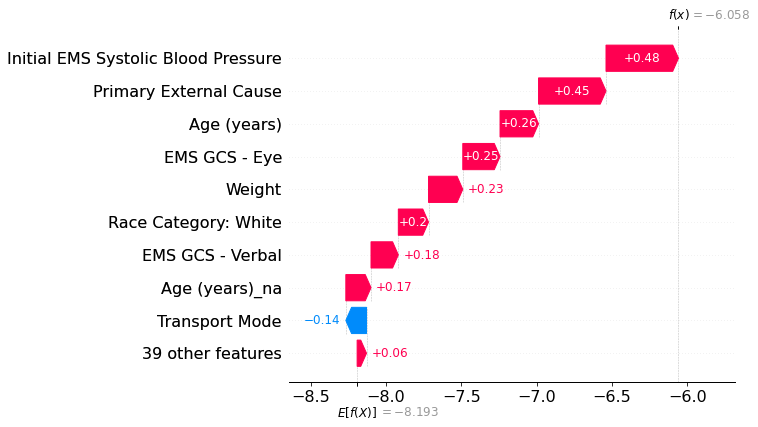

Waterfall Plot for Deep Surgical Site Infection


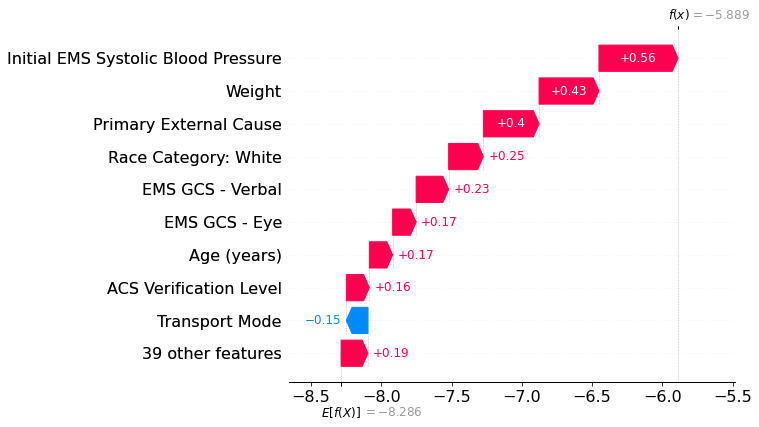

Waterfall Plot for Organspace Surgical Site Infection


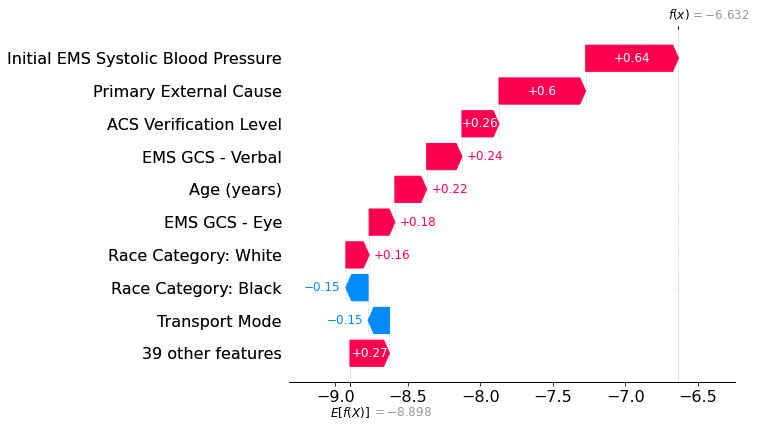

Waterfall Plot for Ventilator-Associated Pneumonia


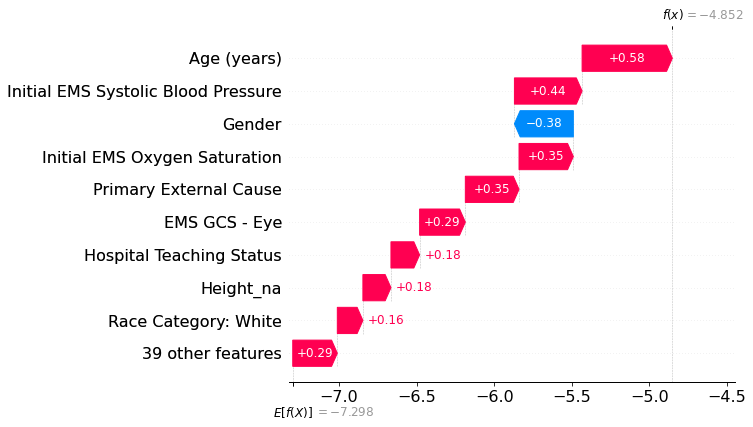

Waterfall Plot for Severe Sepsis


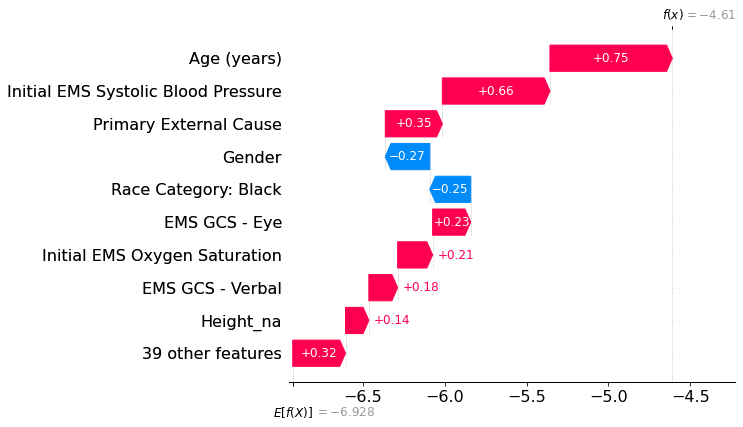

Waterfall Plot for Deep Vein Thrombosis


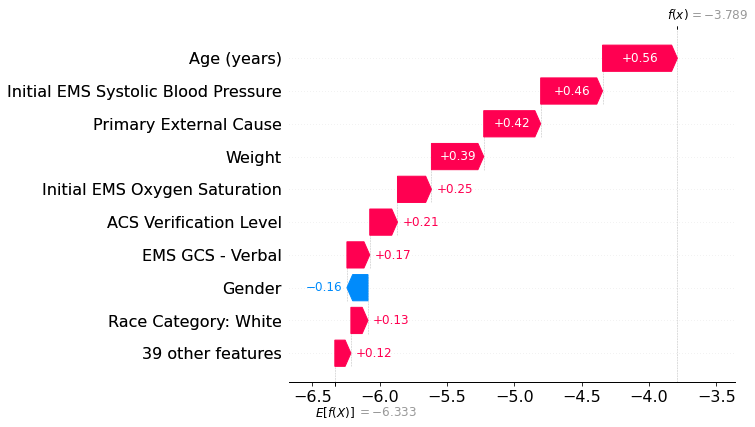

Waterfall Plot for Pulmonary Embolism


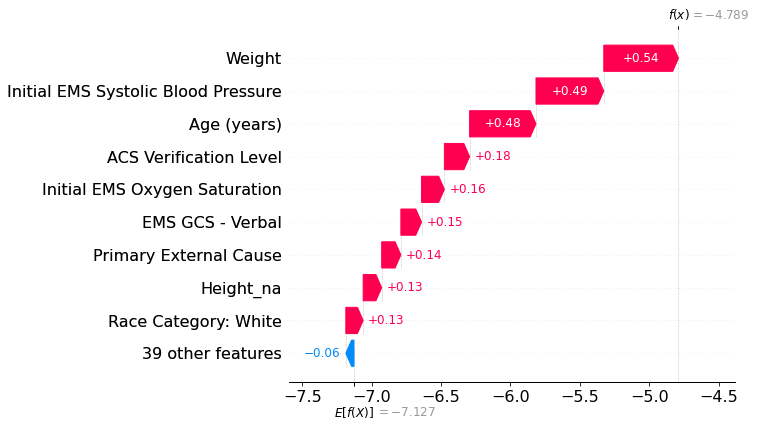

Waterfall Plot for Extremity Compartment Syndrome


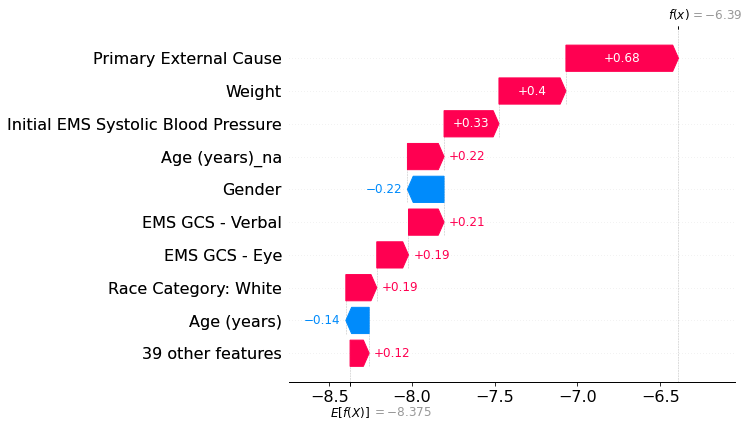

Waterfall Plot for Pressure Ulcer


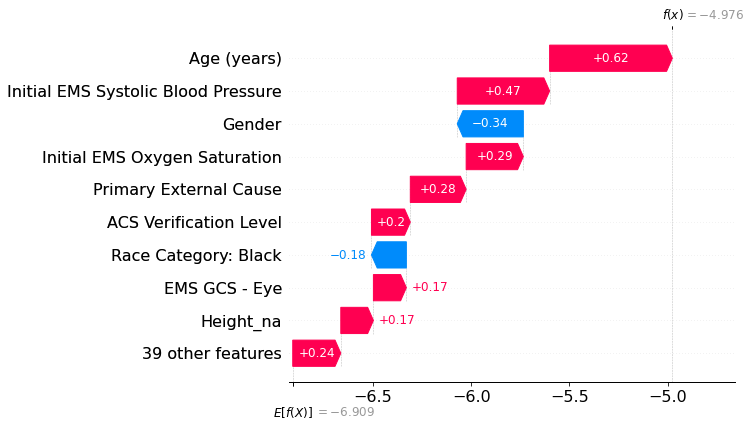

Waterfall Plot for Acute Kidney Injury


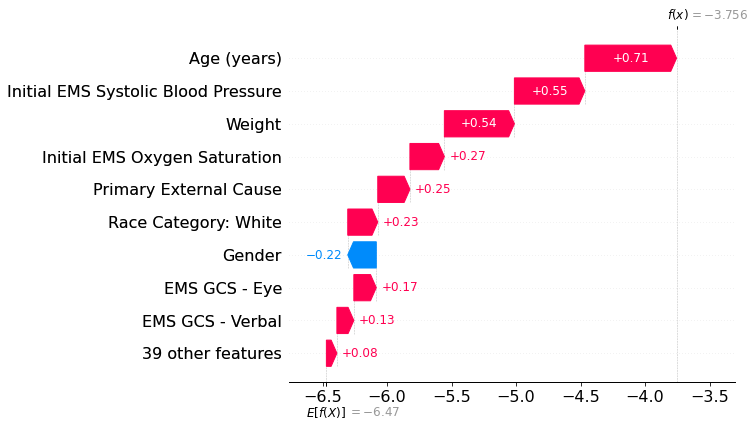

Waterfall Plot for Myocardial Infarction


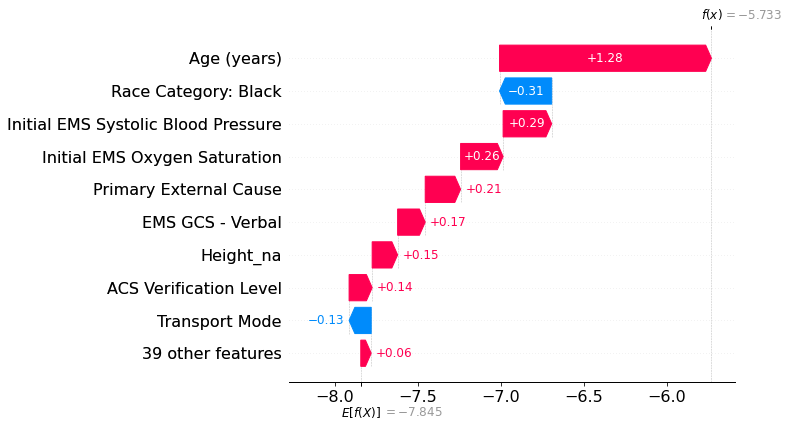

Waterfall Plot for Cardiac Arrest


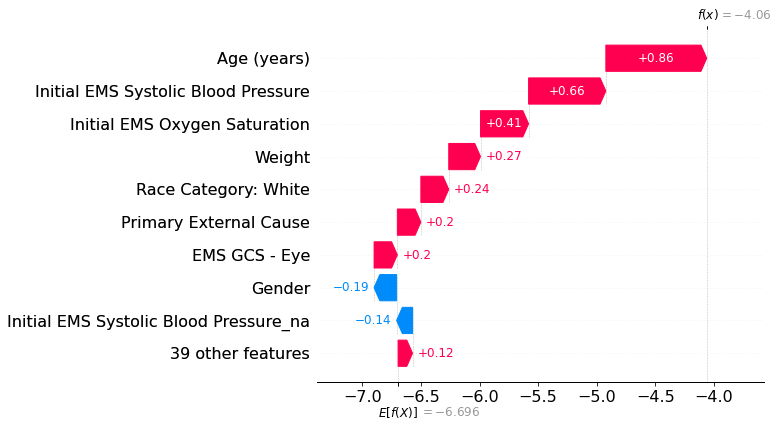

Waterfall Plot for Stroke


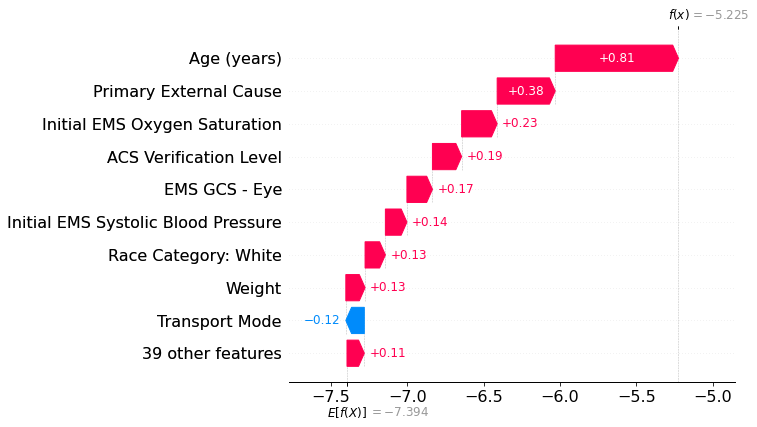

Waterfall Plot for Unplanned Intubation


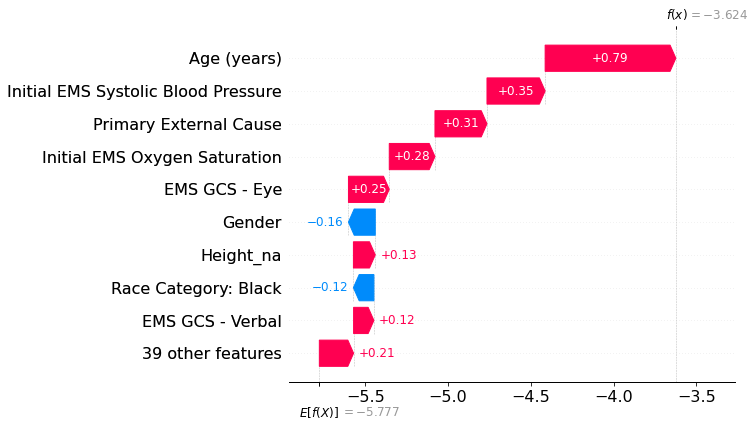

Waterfall Plot for Acute Respiratory Distress Syndrome


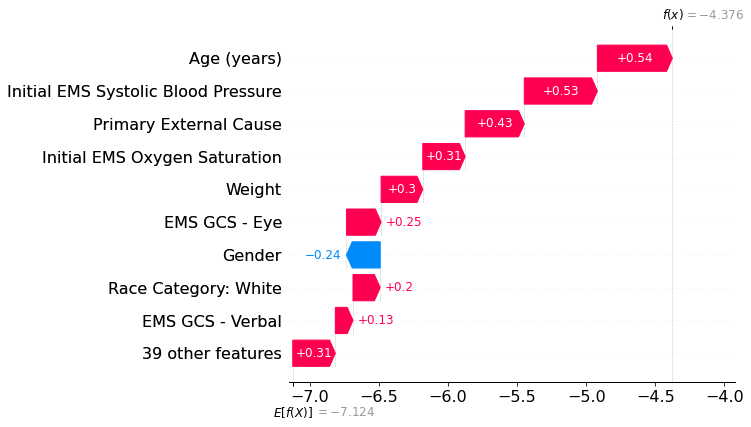

Waterfall Plot for Early Mortality


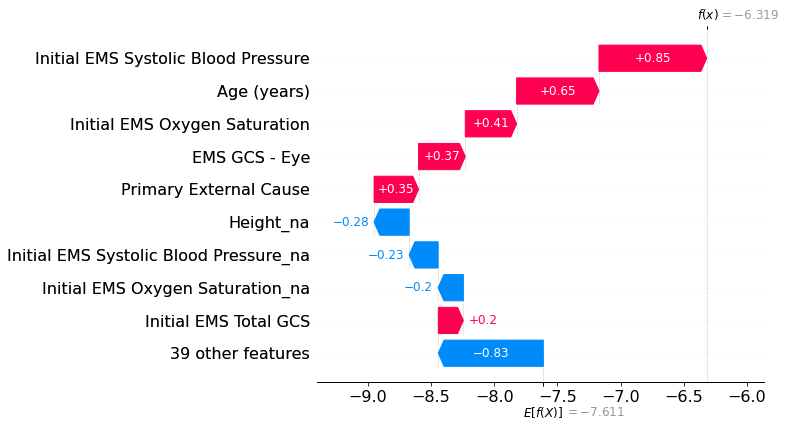

Waterfall Plot for Late Mortality


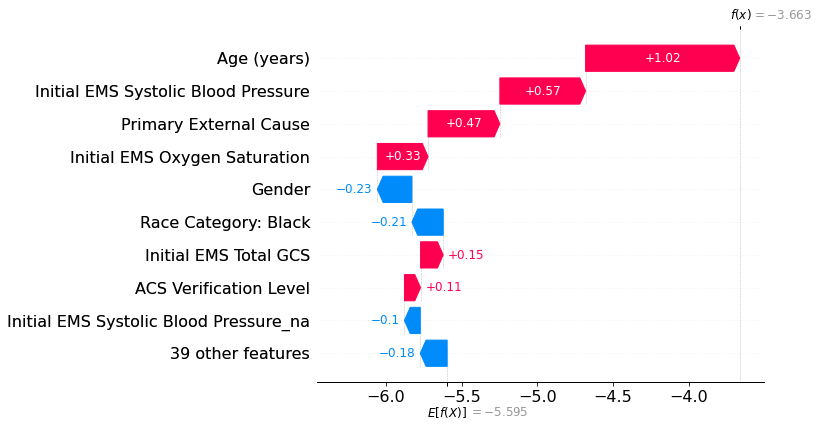

In [35]:
for i in range(len(Pre_Hospital_Model.dls.y_names)):
    print('Waterfall Plot for', Pre_Hospital_Model.dls.y_names[i])
    shap.waterfall_plot(prehosp_explainer.expected_value[i], shap_values = prehosp_shap_vals[i][0], feature_names=df_inf_prehosp.columns)

## ED Predictions: 

Load the ED Model:

In [5]:
ED_Model = load_learner('models/TQIP_ED_Model.pkl')

Remove the ROC AUC metrics

In [6]:
ED_Model.metrics = None

Create a dataloader:

In [7]:
dl_ED = ED_Model.dls.test_dl(df)

Get predictions for the patient:

In [8]:
preds_tens, ys = ED_Model.get_preds(dl=dl_ED, n_workers=0)

In [9]:
print('The ED Risk of:')
for i in range(len(ED_Model.dls.y_names)):
    print('\t' + ED_Model.dls.y_names[i], '=', "{:.2%}".format(preds_tens.tolist()[0][i]))

The ED Risk of:
	Central Line-Associated Bloodstream Infection = 0.20%
	Catheter-Associated Urinary Tract Infection = 1.36%
	Superficial Incisional Surgical Site Infection = 0.31%
	Deep Surgical Site Infection = 0.74%
	Organspace Surgical Site Infection = 0.23%
	Ventilator-Associated Pneumonia = 1.32%
	Severe Sepsis = 4.88%
	Deep Vein Thrombosis = 5.12%
	Pulmonary Embolism = 0.92%
	Extremity Compartment Syndrome = 0.23%
	Pressure Ulcer = 3.74%
	Acute Kidney Injury = 8.17%
	Myocardial Infarction = 2.70%
	Cardiac Arrest = 9.85%
	Stroke = 1.12%
	Unplanned Intubation = 10.82%
	Acute Respiratory Distress Syndrome = 2.40%
	Early Mortality = 0.55%
	Late Mortality = 17.89%


### Explain predictions using SHAP:

Load the ED explainer:

In [10]:
ED_explainer = joblib.load(filename='explainers/ED_explainer.bz2')

Prepare the data for ED explanations:  

In [11]:
df_inf_ED = _prepare_data(ED_Model, df) 

Calculate shap values: 

In [12]:
ED_shap_vals = ED_explainer.shap_values(df_inf_ED)

Waterfall Plot for Central Line-Associated Bloodstream Infection


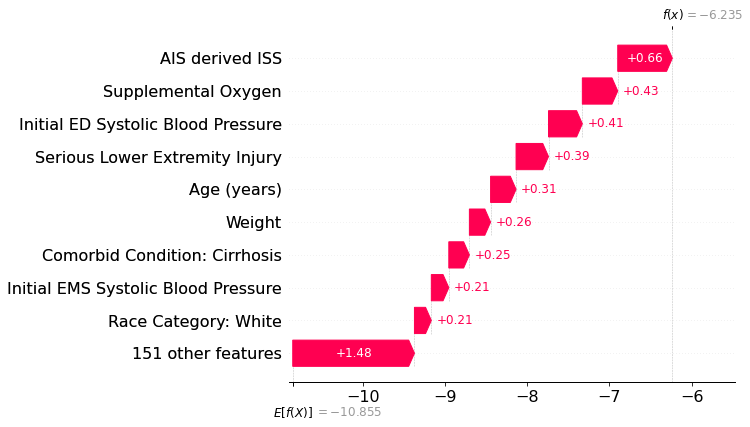

Waterfall Plot for Catheter-Associated Urinary Tract Infection


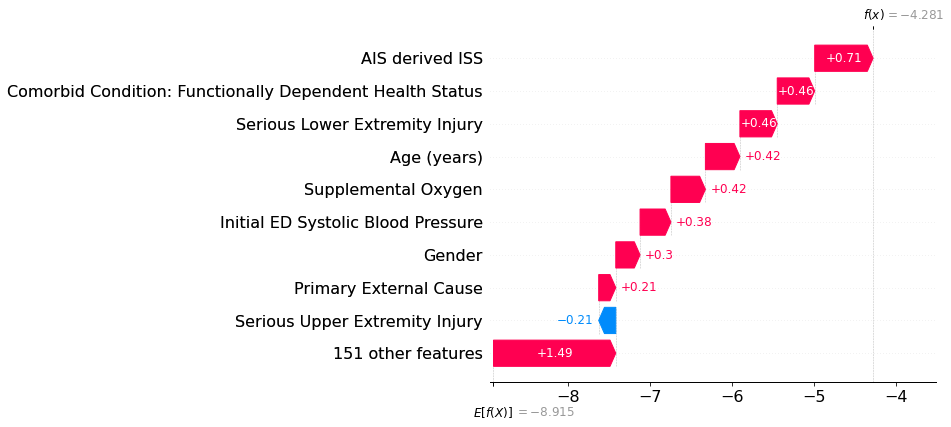

Waterfall Plot for Superficial Incisional Surgical Site Infection


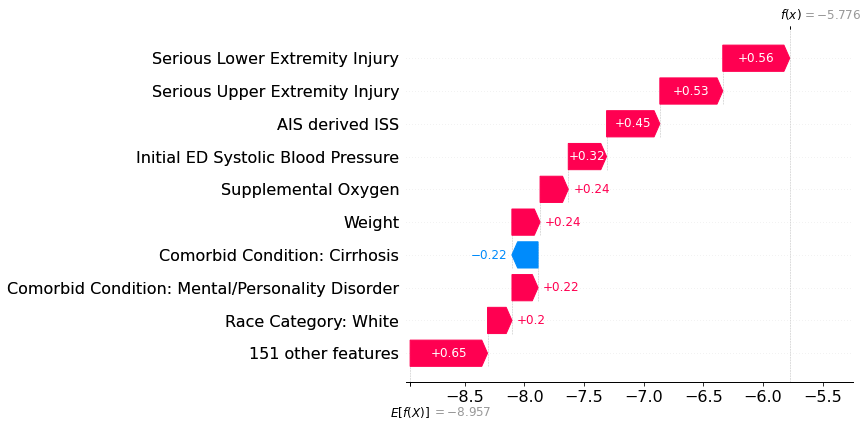

Waterfall Plot for Deep Surgical Site Infection


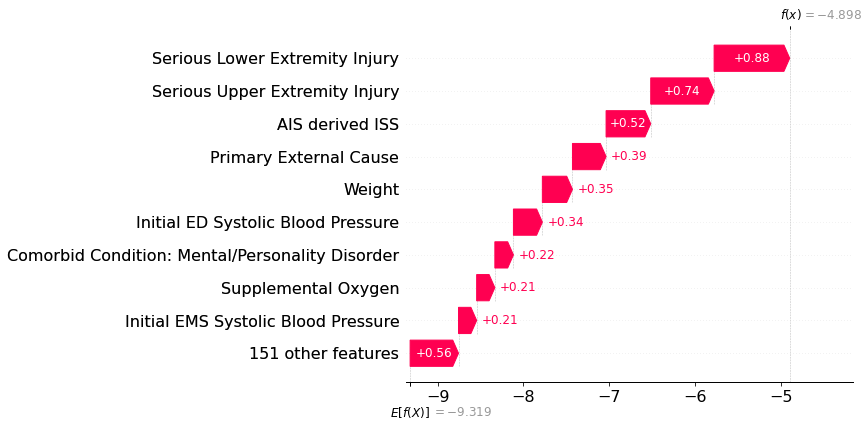

Waterfall Plot for Organspace Surgical Site Infection


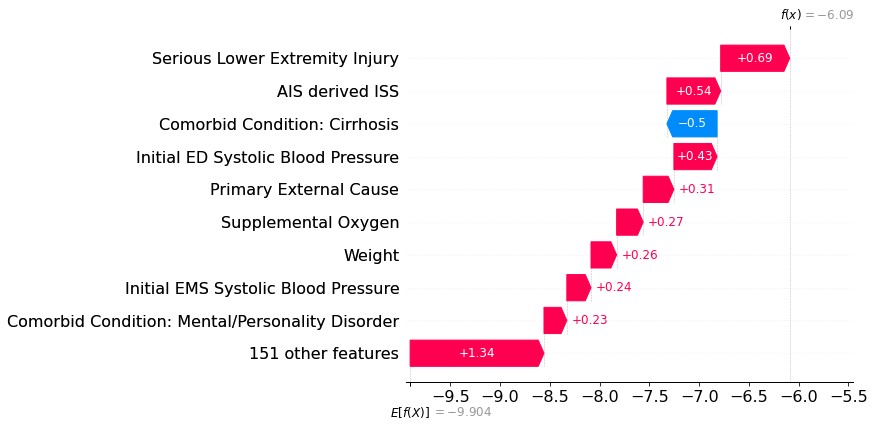

Waterfall Plot for Ventilator-Associated Pneumonia


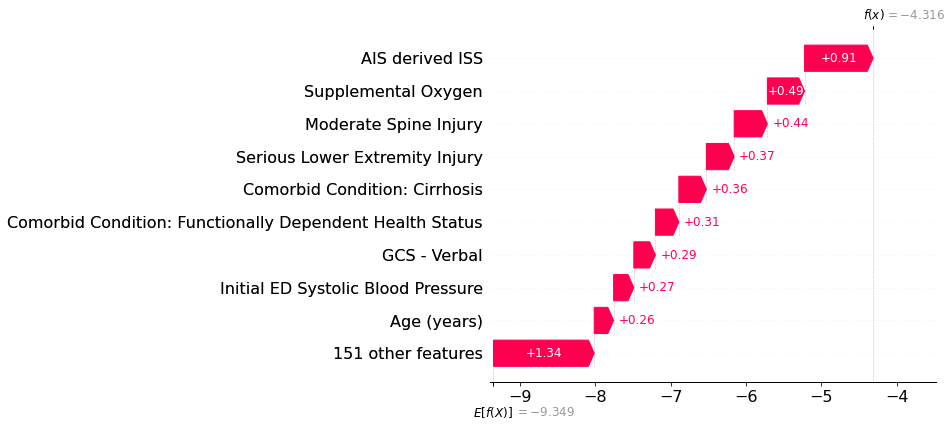

Waterfall Plot for Severe Sepsis


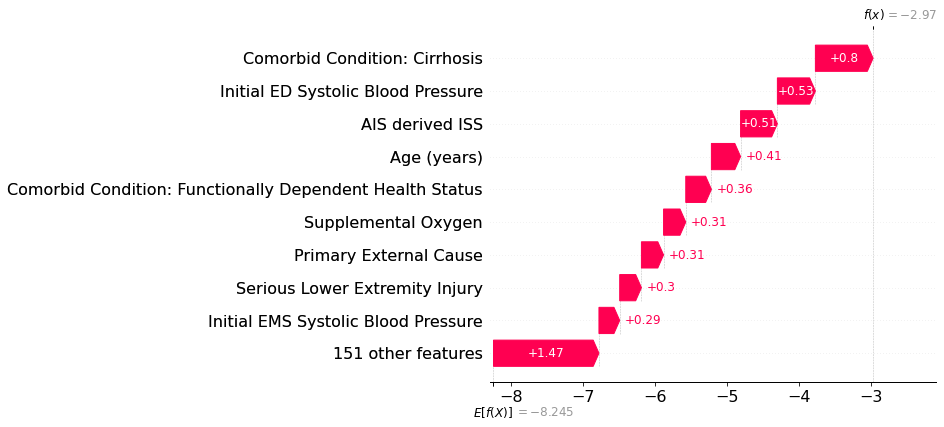

Waterfall Plot for Deep Vein Thrombosis


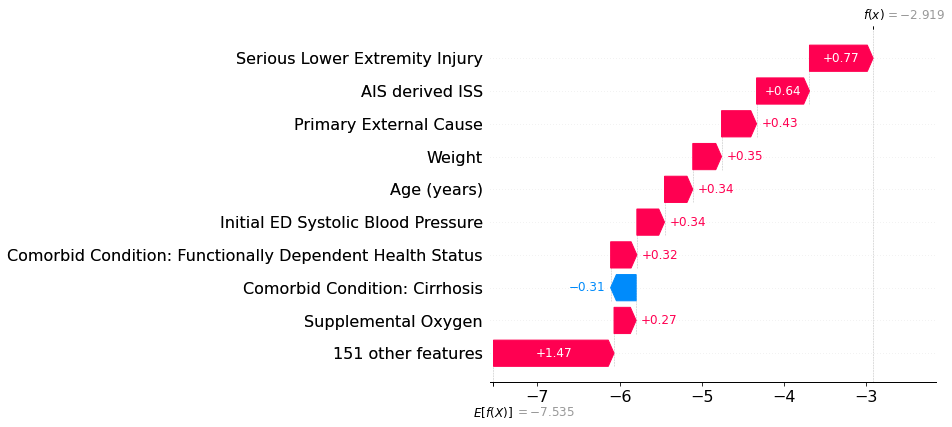

Waterfall Plot for Pulmonary Embolism


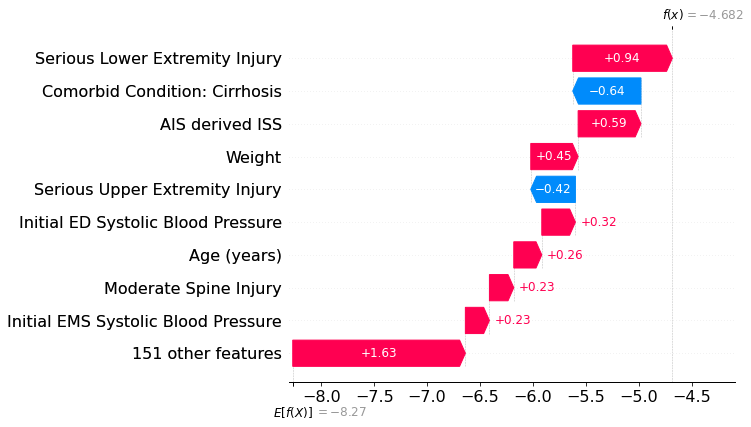

Waterfall Plot for Extremity Compartment Syndrome


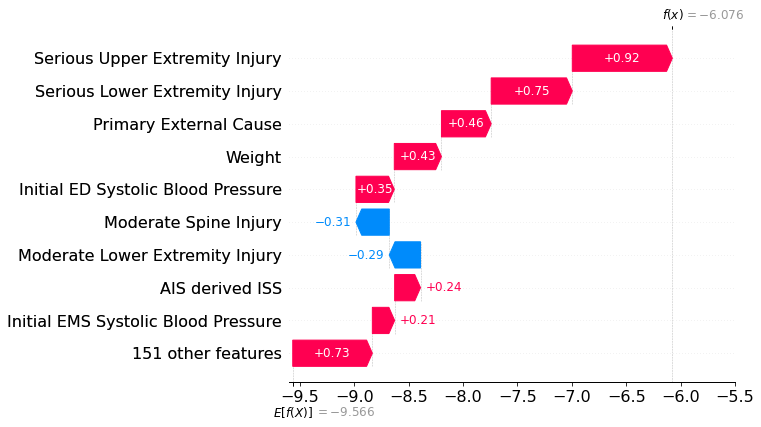

Waterfall Plot for Pressure Ulcer


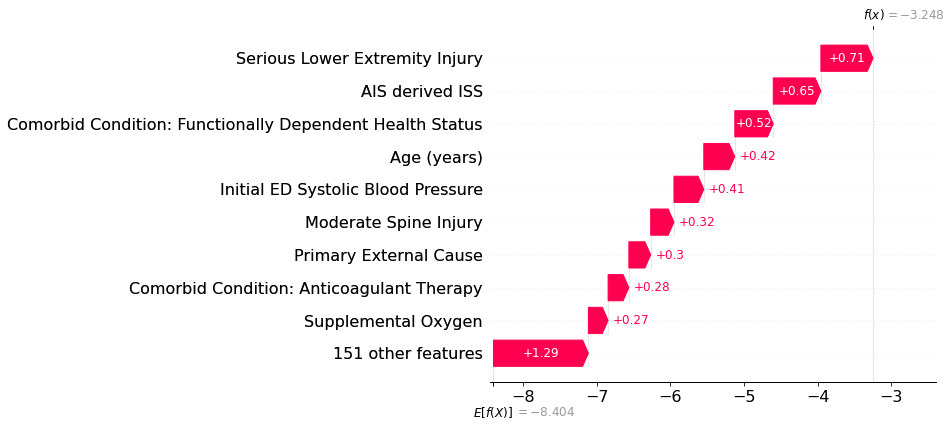

Waterfall Plot for Acute Kidney Injury


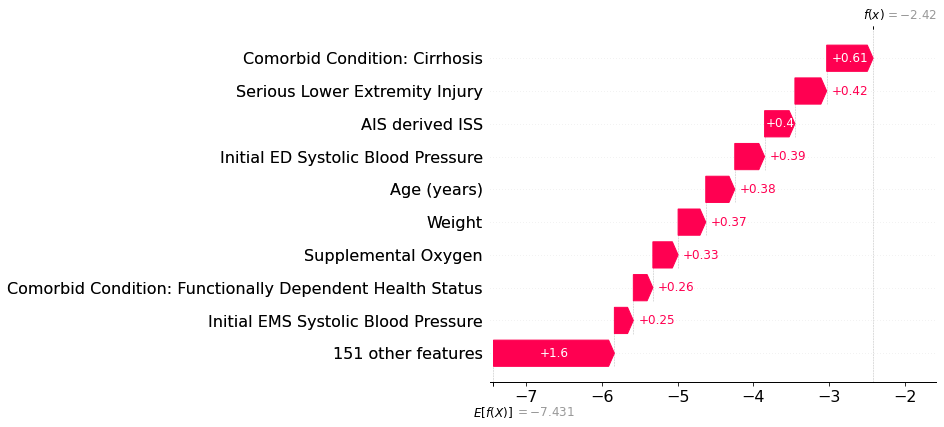

Waterfall Plot for Myocardial Infarction


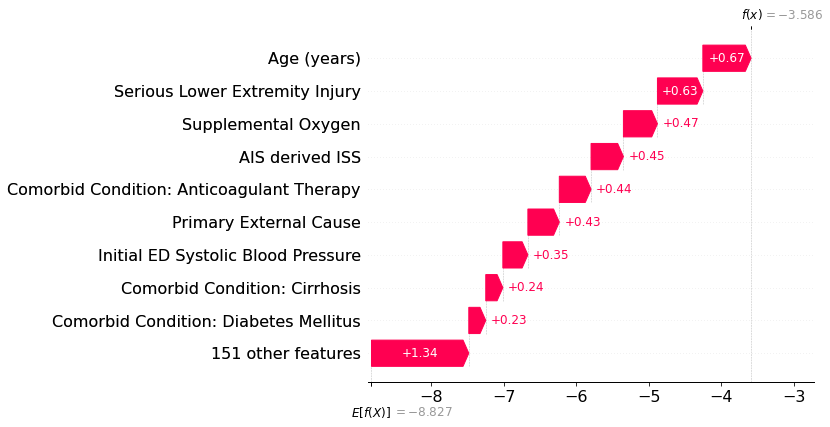

Waterfall Plot for Cardiac Arrest


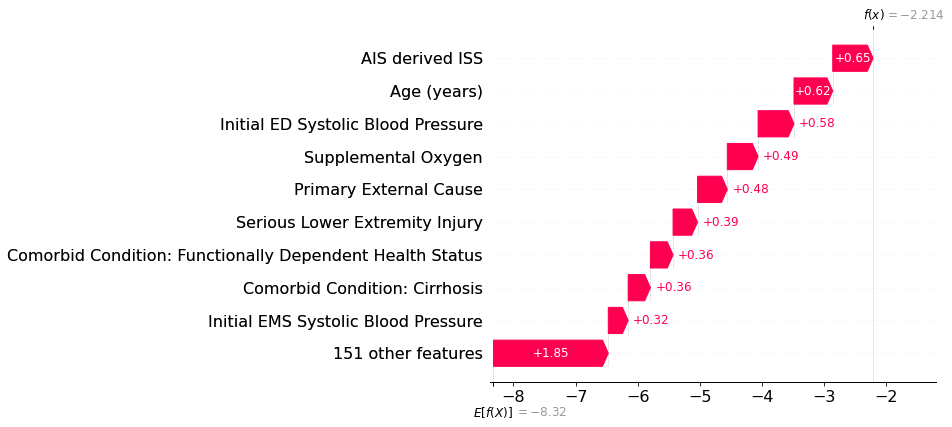

Waterfall Plot for Stroke


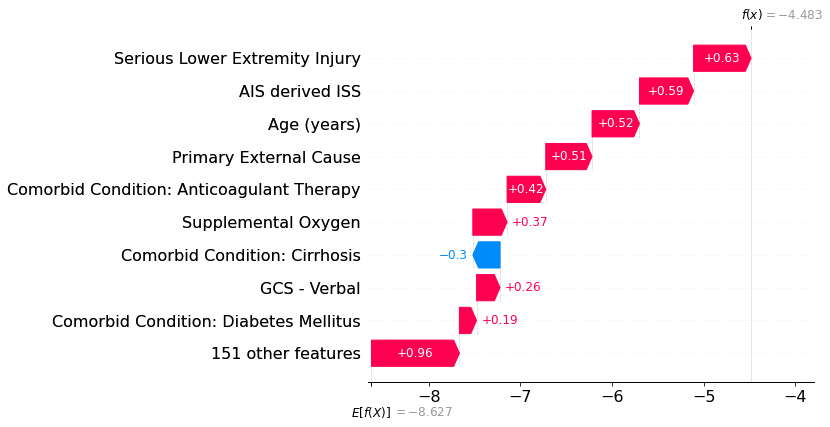

Waterfall Plot for Unplanned Intubation


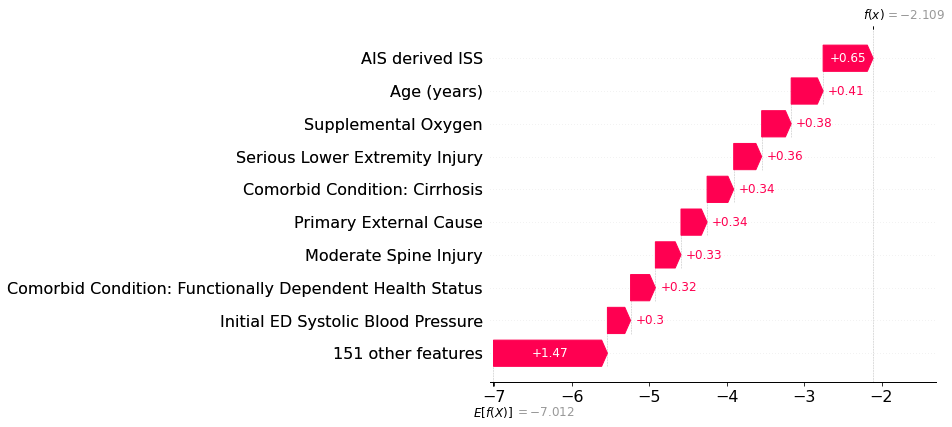

Waterfall Plot for Acute Respiratory Distress Syndrome


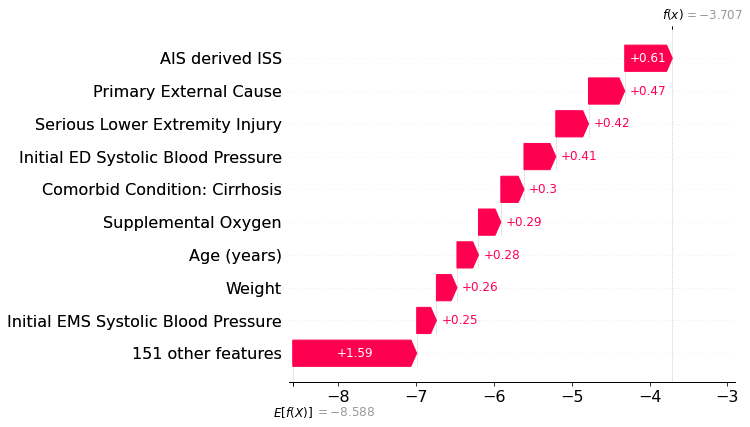

Waterfall Plot for Early Mortality


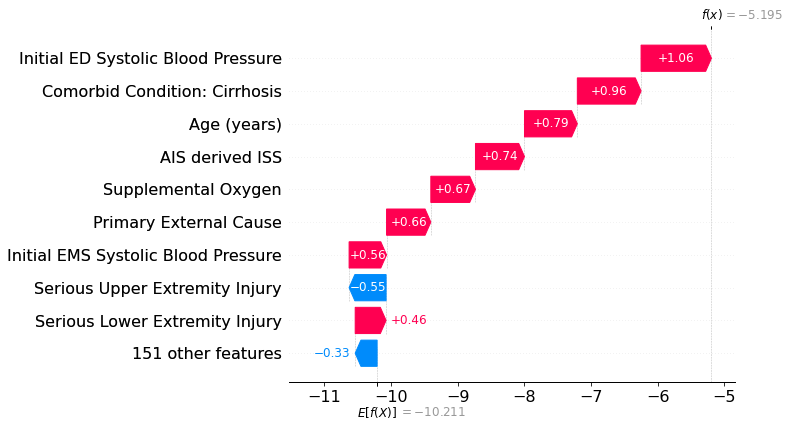

Waterfall Plot for Late Mortality


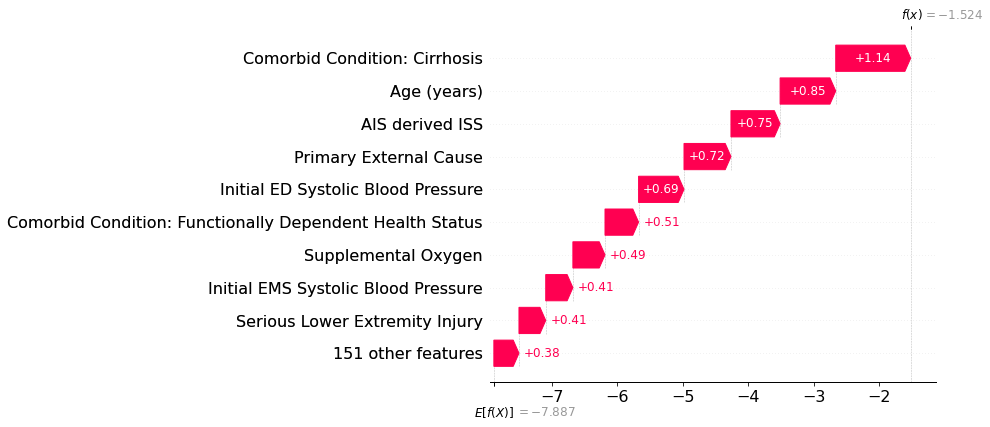

In [13]:
for i in range(len(ED_Model.dls.y_names)):
    print('Waterfall Plot for', ED_Model.dls.y_names[i])
    shap.waterfall_plot(ED_explainer.expected_value[i], shap_values = ED_shap_vals[i][0], feature_names=df_inf_ED.columns)

## In-Hospital Predictions: 

Load the In-Hospital Model:

In [5]:
In_Hospital_Model = load_learner('models/TQIP_In-Hospital_Model.pkl')

Remove the ROC AUC metrics

In [6]:
In_Hospital_Model.metrics = None

Create a dataloader:

In [7]:
dl_inhosp = In_Hospital_Model.dls.test_dl(df)

Get predictions for the patient:

In [8]:
preds_tens, ys = In_Hospital_Model.get_preds(dl=dl_inhosp, n_workers=0)

In [9]:
print('The In-Hospital Risk of:')
for i in range(len(In_Hospital_Model.dls.y_names)):
    print('\t' + In_Hospital_Model.dls.y_names[i], '=', "{:.2%}".format(preds_tens.tolist()[0][i]))

The In-Hospital Risk of:
	Central Line-Associated Bloodstream Infection = 0.12%
	Catheter-Associated Urinary Tract Infection = 0.59%
	Superficial Incisional Surgical Site Infection = 0.19%
	Deep Surgical Site Infection = 0.36%
	Organspace Surgical Site Infection = 0.13%
	Ventilator-Associated Pneumonia = 0.42%
	Severe Sepsis = 3.50%
	Deep Vein Thrombosis = 1.35%
	Pulmonary Embolism = 0.64%
	Extremity Compartment Syndrome = 0.10%
	Pressure Ulcer = 1.77%
	Acute Kidney Injury = 8.57%
	Myocardial Infarction = 2.21%
	Cardiac Arrest = 5.60%
	Stroke = 0.57%
	Unplanned Intubation = 6.50%
	Acute Respiratory Distress Syndrome = 1.13%
	Late Mortality = 10.93%


### Explain predictions using SHAP:

Load the In-Hospital explainer:

In [10]:
inhosp_explainer = joblib.load(filename='explainers/inhosp_explainer.bz2')

Prepare the data for In-Hospital explanations:  

In [11]:
df_inf_inhosp = _prepare_data(In_Hospital_Model, df) 

Calculate shap values: 

In [12]:
inhosp_shap_vals = inhosp_explainer.shap_values(df_inf_inhosp)

Waterfall Plot for Central Line-Associated Bloodstream Infection


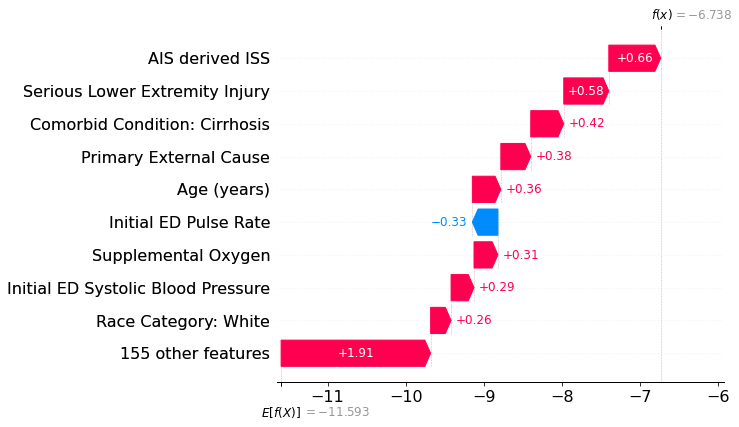

Waterfall Plot for Catheter-Associated Urinary Tract Infection


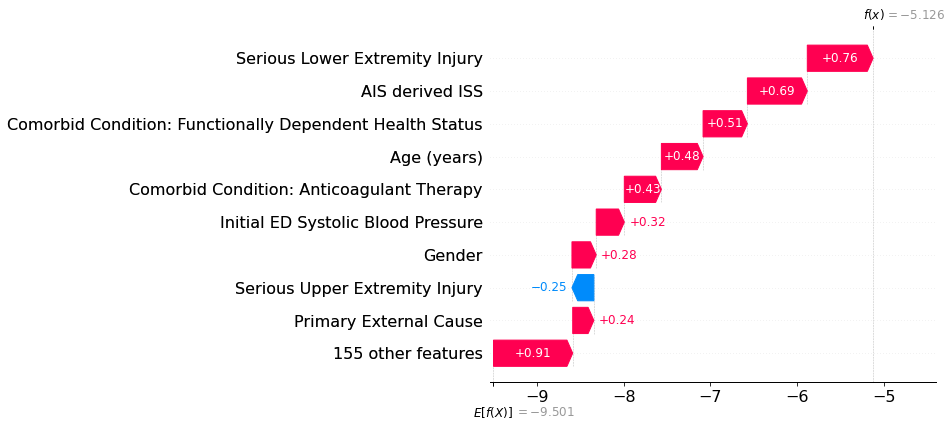

Waterfall Plot for Superficial Incisional Surgical Site Infection


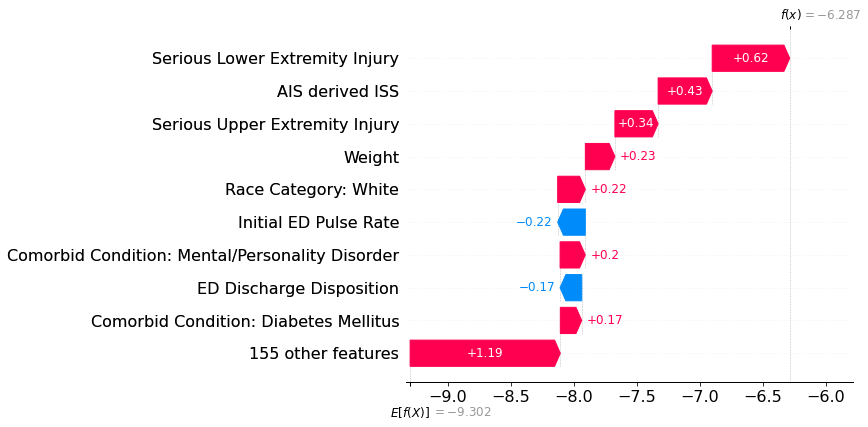

Waterfall Plot for Deep Surgical Site Infection


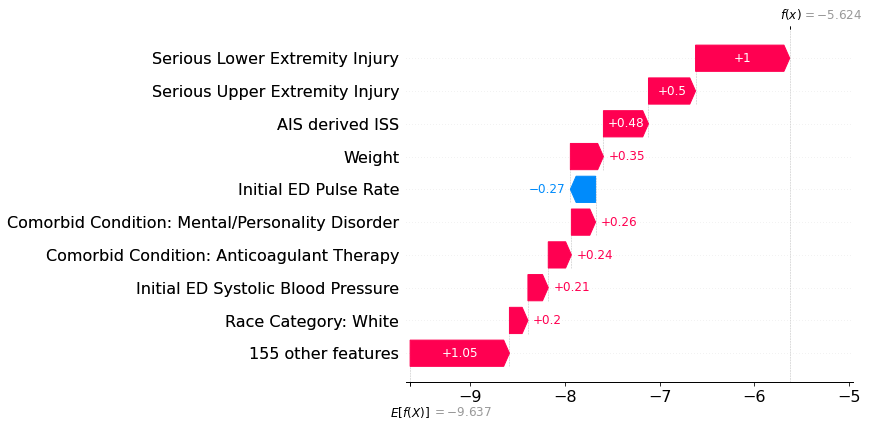

Waterfall Plot for Organspace Surgical Site Infection


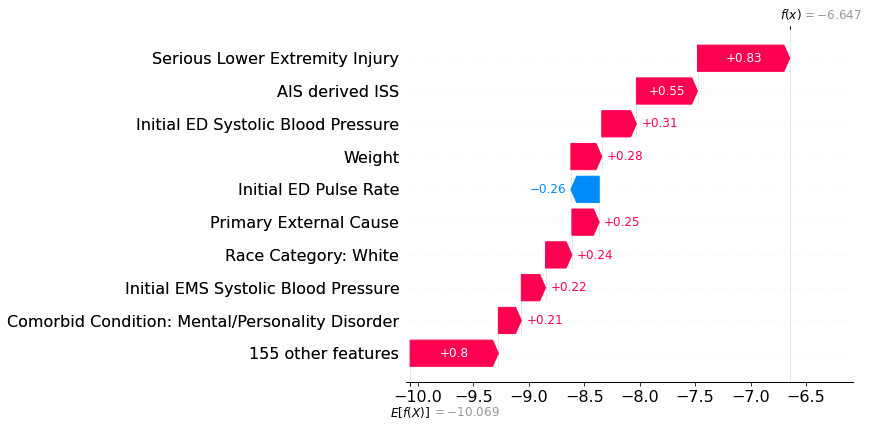

Waterfall Plot for Ventilator-Associated Pneumonia


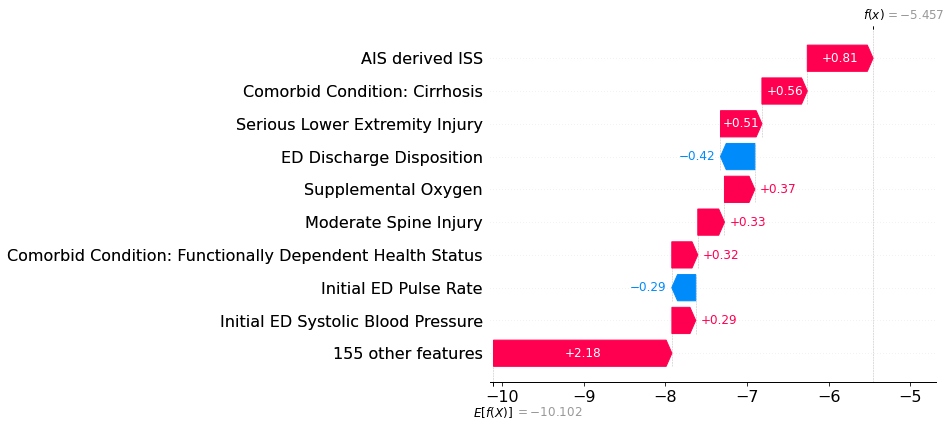

Waterfall Plot for Severe Sepsis


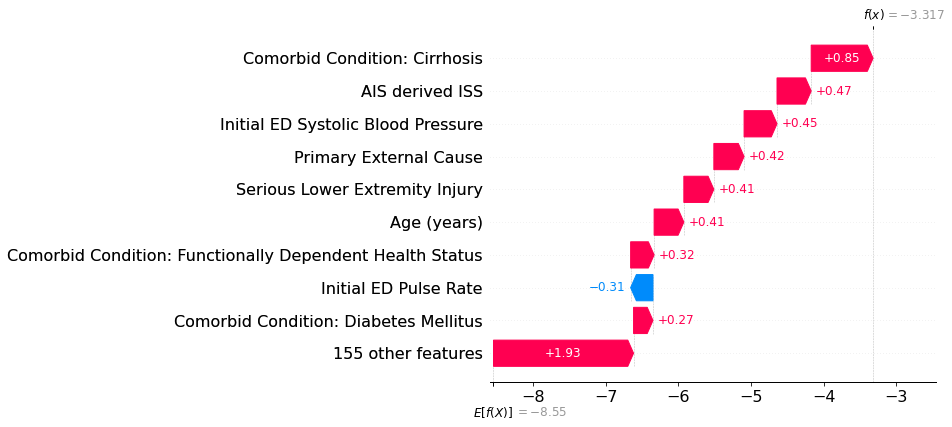

Waterfall Plot for Deep Vein Thrombosis


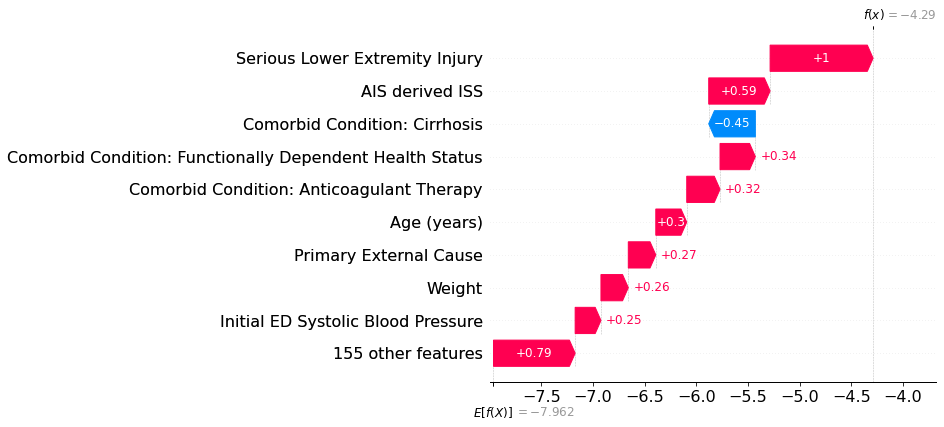

Waterfall Plot for Pulmonary Embolism


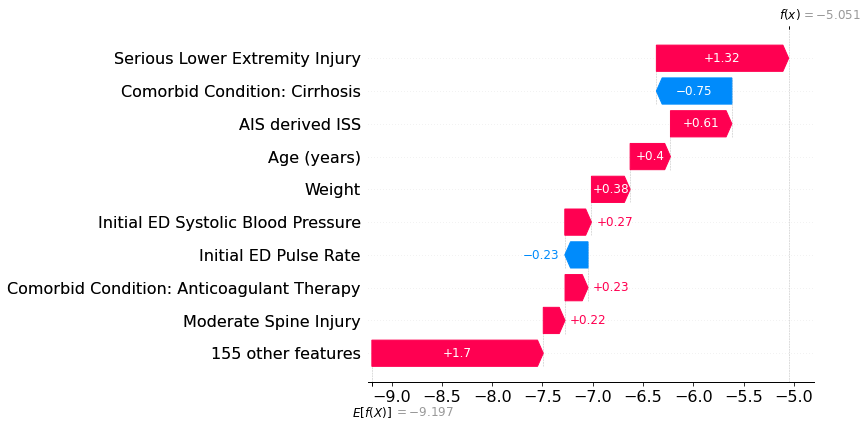

Waterfall Plot for Extremity Compartment Syndrome


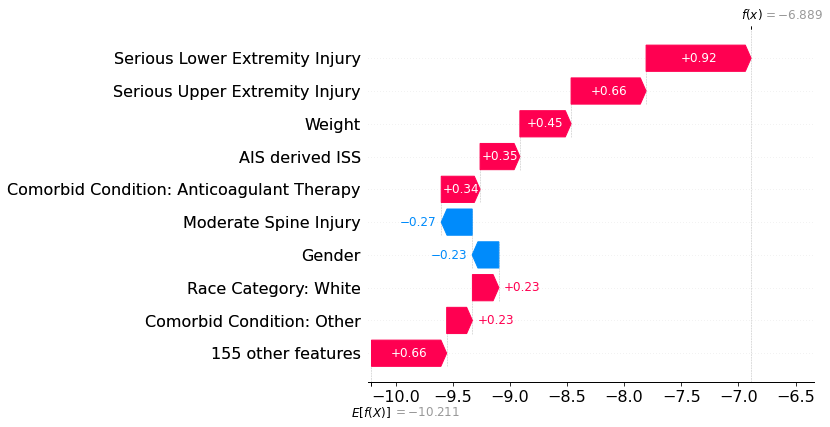

Waterfall Plot for Pressure Ulcer


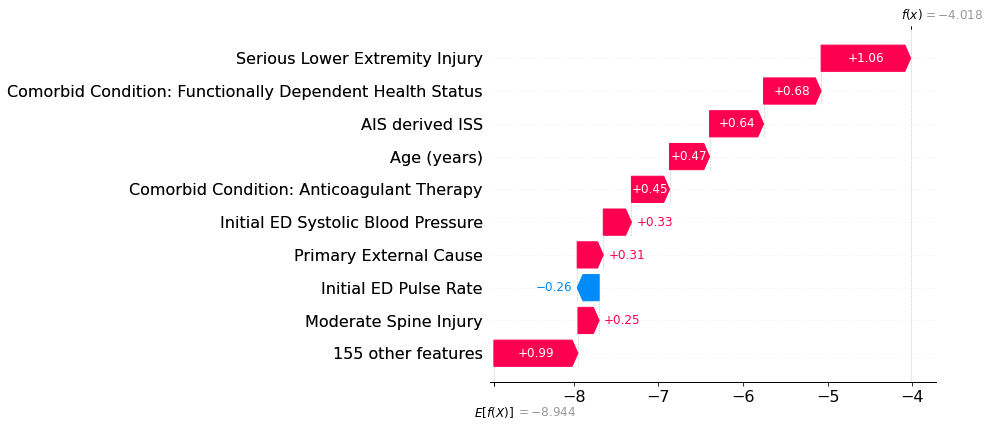

Waterfall Plot for Acute Kidney Injury


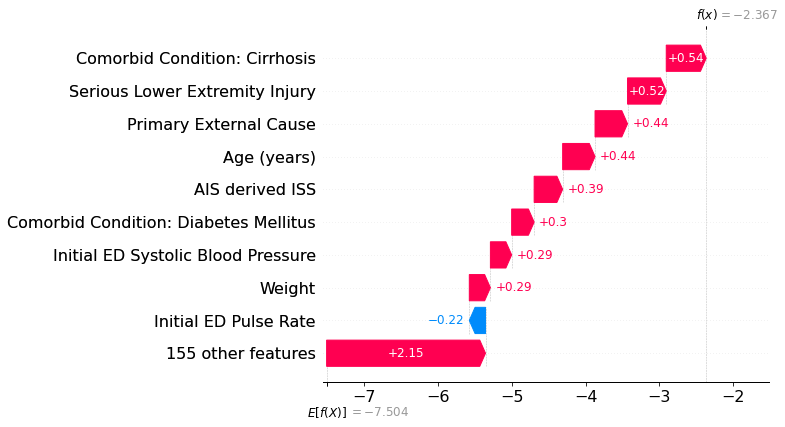

Waterfall Plot for Myocardial Infarction


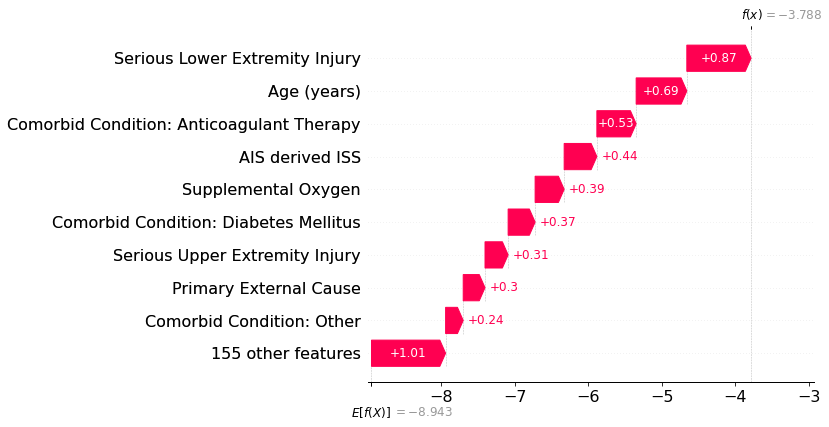

Waterfall Plot for Cardiac Arrest


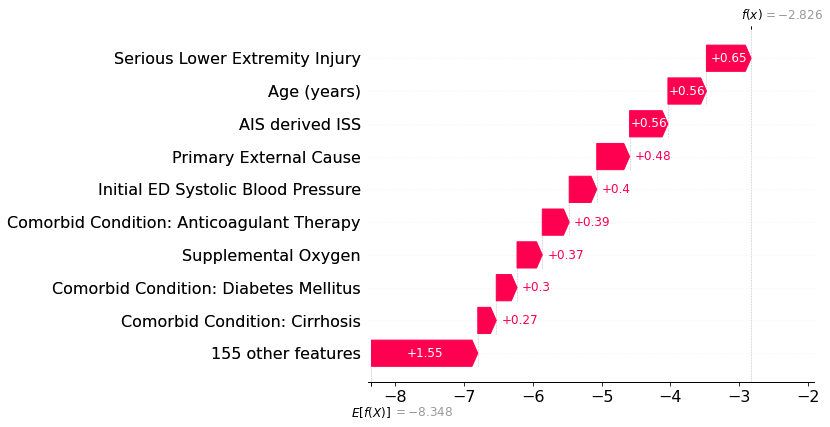

Waterfall Plot for Stroke


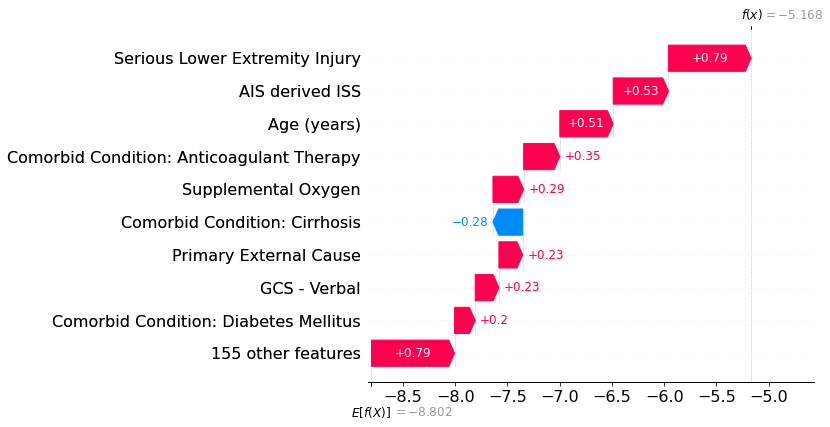

Waterfall Plot for Unplanned Intubation


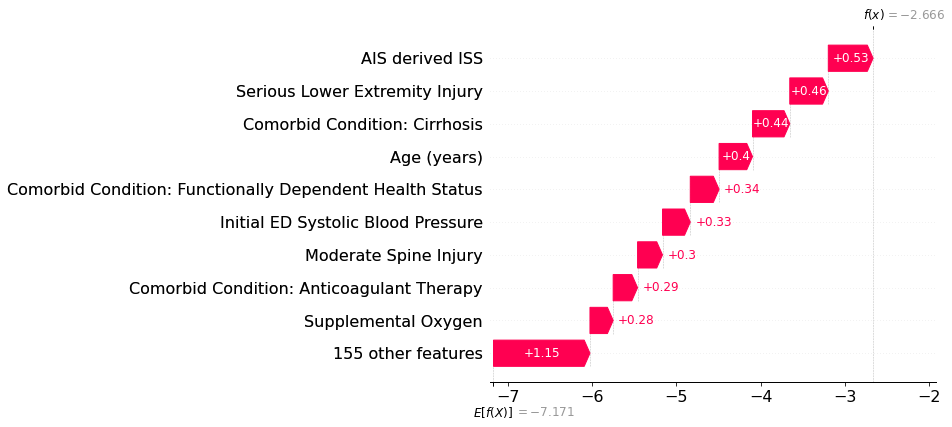

Waterfall Plot for Acute Respiratory Distress Syndrome


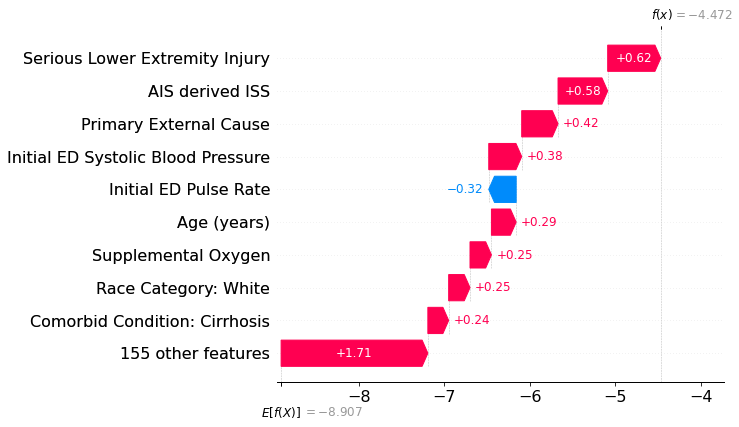

Waterfall Plot for Late Mortality


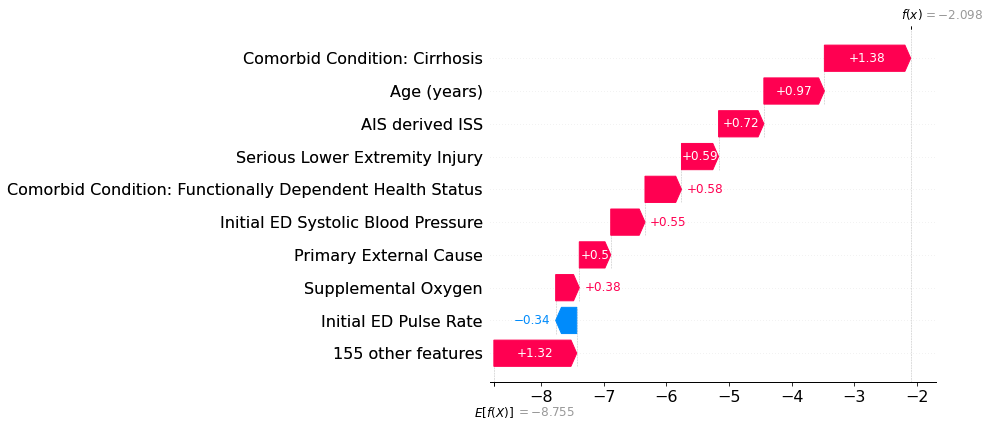

In [13]:
for i in range(len(In_Hospital_Model.dls.y_names)):
    print('Waterfall Plot for', In_Hospital_Model.dls.y_names[i])
    shap.waterfall_plot(inhosp_explainer.expected_value[i], shap_values = inhosp_shap_vals[i][0], feature_names=df_inf_inhosp.columns)